PRE PROCESSING

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 100.1 MB/s eta 0:00:00


In [30]:
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence

import torch

# Carregar o tokenizer BERT pré-treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Função para realizar o pré-processamento e conversão em representações numéricas
def preprocess_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    processed_data = []

    for line in lines:
        # Limpeza de texto
        cleaned_text = line.strip()

        # Tokenização
        tokens = tokenizer.tokenize(cleaned_text)

        # Conversão em representações numéricas
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # Preparação dos dados como tensors
        input_ids = torch.tensor(input_ids)

        # Adicionar dados pré-processados à lista
        processed_data.append(input_ids)

    return processed_data

In [76]:
from torch.nn.functional import pad

# Caminhos dos arquivos de dados
positive_file = '/content/drive/MyDrive/tweet_data/positive.txt'
negative_file = '/content/drive/MyDrive/tweet_data/negative.txt'

# Pré-processamento dos dados positivos
positive_data = preprocess_data(positive_file)

# Pré-processamento dos dados negativos
negative_data = preprocess_data(negative_file)

# Função para ajustar o tamanho dos tensores com padding
def pad_data(data):
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    return padded_data

# Ajustar o tamanho dos tensores positive_data e negative_data
positive_data = pad_data(positive_data)
negative_data = pad_data(negative_data)

# Exemplo de exibição dos dados pré-processados
print("Exemplo de dado pré-processado:")
print(positive_data[1])
print(negative_data[0])


Exemplo de dado pré-processado:
tensor([   157,  13034,  95825,  11090,    131,  91327,  13028,  10142,  10105,
         10751, 105741,    119,    146,  16138,  13028,    119,    137,  99843,
         24951,  10729,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0])
tensor([  157, 13034, 95825, 11090,   131,   146, 30181, 28870, 81160, 16070,
        14075, 10160, 62006, 14128, 10635, 26506, 10237,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0])


BERT TRAINING

In [72]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Definir classe Dataset personalizada
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Carregar o tokenizer BERT pré-treinado
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Definir o modelo BERT para classificação de sequência
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

# Definir hiperparâmetros
batch_size = 16
lr = 2e-5
num_epochs = 10

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

In [79]:
# Verificar o tamanho máximo entre positive_data e negative_data
max_len = max(len(positive_data[0]), len(negative_data[0]))

# Função para ajustar o tamanho dos tensores com padding até max_len
def pad_data_fixed_size(data, max_len):
    padded_data = pad_sequence(data, batch_first=True, padding_value=0)
    padded_data = padded_data[:, :max_len]
    padded_data = pad(padded_data, (0, max_len - padded_data.size(1)), value=0)
    return padded_data

# Ajustar o tamanho dos tensores positive_data e negative_data
positive_data = pad_data_fixed_size(positive_data, max_len)
negative_data = pad_data_fixed_size(negative_data, max_len)

# Exemplo de exibição dos dados pré-processados
print("Exemplo de dado pré-processado:")
print(positive_data[1])
print(negative_data[0])

# Converter os rótulos para tensores
positive_labels = torch.tensor([1] * len(positive_data))
negative_labels = torch.tensor([0] * len(negative_data))

# Concatenar dados e rótulos
all_data = torch.cat((positive_data, negative_data))
all_labels = torch.cat((positive_labels, negative_labels))

# Criar instâncias da classe Dataset
dataset = CustomDataset(all_data, all_labels)

Exemplo de dado pré-processado:
tensor([   157,  13034,  95825,  11090,    131,  91327,  13028,  10142,  10105,
         10751, 105741,    119,    146,  16138,  13028,    119,    137,  99843,
         24951,  10729,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0])
tensor([  157, 13034, 95825, 11090,   131,   146, 30181, 28870, 81160, 16070,
        14075, 10160, 62006, 14128, 10635, 26506, 10237,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    

In [80]:
# Dividir o conjunto de dados em treino, validação e teste
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [81]:
# Criar DataLoaders para treino, validação e teste
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [82]:
# Definir otimizador e função de perda
optimizer = AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss()

# Função para calcular a acurácia
def accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [83]:
# Listas para armazenar as curvas de loss
train_loss_history = []
val_loss_history = []

# Loop de treinamento
for epoch in range(num_epochs):
    # Modo de treinamento
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in train_dataloader:
        # Limpar os gradientes
        model.zero_grad()

        # Preparar os dados de entrada
        inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
        labels = labels.to(torch.long)

        # Obter as saídas do modelo
        outputs = model(inputs, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        # Atualizar os parâmetros do modelo
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(logits, labels)

    # Calcular a média das perdas e acurácia de treinamento
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # Modo de avaliação
    model.eval()
    val_loss = 0.0
    val_acc = 0.0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
            labels = labels.to(torch.long)

            outputs = model(inputs, labels=labels)
            loss, logits = outputs.loss, outputs.logits

            val_loss += loss.item()
            val_acc += accuracy(logits, labels)

    # Calcular a média das perdas e acurácia de validação
    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # Registrar as perdas de treinamento e validação
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Imprimir métricas do treinamento e validação
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}')
    print('-----------------------------------------')


Epoch 1/10:
Train Loss: 0.6758 | Train Accuracy: 0.5417
Val Loss: 0.5024 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 2/10:
Train Loss: 0.5243 | Train Accuracy: 0.7812
Val Loss: 0.2669 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 3/10:
Train Loss: 0.5021 | Train Accuracy: 0.7500
Val Loss: 0.3951 | Val Accuracy: 0.8182
-----------------------------------------
Epoch 4/10:
Train Loss: 0.4754 | Train Accuracy: 0.8021
Val Loss: 0.1251 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 5/10:
Train Loss: 0.4092 | Train Accuracy: 0.8229
Val Loss: 0.1069 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 6/10:
Train Loss: 0.2955 | Train Accuracy: 0.8750
Val Loss: 0.0809 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 7/10:
Train Loss: 0.2679 | Train Accuracy: 0.9479
Val Loss: 0.0615 | Val Accuracy: 1.0000
-----------------------------------------
Epoch 8/10:
Train Loss: 0.2139 | T

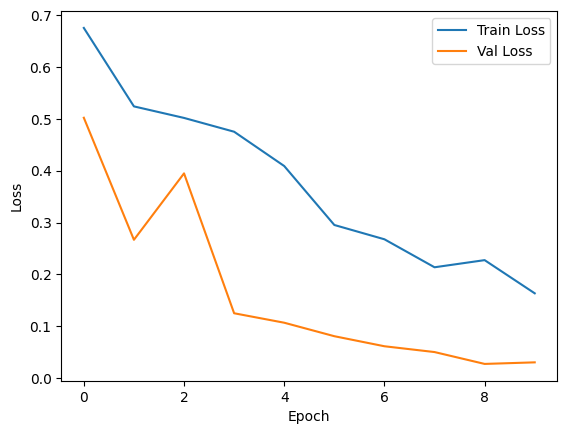

In [84]:
# Plotar a curva de loss do treinamento e validação
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
# Modo de avaliação no conjunto de teste
model.eval()
test_loss = 0.0
test_acc = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = pad(inputs, (0, 70 - inputs.size(1)), value=0).to(torch.long)
        labels = labels.to(torch.long)

        outputs = model(inputs, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        test_loss += loss.item()
        test_acc += accuracy(logits, labels)

        # Armazenar as previsões e rótulos verdadeiros para a matriz de confusão e classification report
        predicted_labels = torch.argmax(logits, dim=1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())

# Calcular a média das perdas e acurácia de teste
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)

# Imprimir métricas do conjunto de teste
print('Test Metrics:')
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')
print('-----------------------------------------')

# Calcular a matriz de confusão e classification report
cm = confusion_matrix(true_labels, predictions)
classification_rep = classification_report(true_labels, predictions)

# Imprimir a matriz de confusão
print('Confusion Matrix:')
print(cm)
print('-----------------------------------------')

# Imprimir o classification report
print('Classification Report:')
print(classification_rep)

Test Metrics:
Test Loss: 0.4132 | Test Accuracy: 0.8333
-----------------------------------------
Confusion Matrix:
[[3 0]
 [2 7]]
-----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.78      0.88         9

    accuracy                           0.83        12
   macro avg       0.80      0.89      0.81        12
weighted avg       0.90      0.83      0.84        12



In [90]:
# Caminho para salvar o modelo
model_path = "/content/data/model"
tokenizer_path = "/content/data/tokenizer"

# Salvar o modelo
model.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)


('/content/data/tokenizer/tokenizer_config.json',
 '/content/data/tokenizer/special_tokens_map.json',
 '/content/data/tokenizer/vocab.txt',
 '/content/data/tokenizer/added_tokens.json')

EXCTRATION TWITTER

In [99]:
!pip3 install git+https://github.com/JustAnotherArchivist/snscrape.git
!pip install snscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/JustAnotherArchivist/snscrape.git to /tmp/pip-req-build-f6jn6n7y
  Running command git clone --filter=blob:none --quiet https://github.com/JustAnotherArchivist/snscrape.git /tmp/pip-req-build-f6jn6n7y
  Resolved https://github.com/JustAnotherArchivist/snscrape.git to commit 614d4c2029a62d348ca56598f87c425966aaec66
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
import snscrape.modules.twitter as sns
from torch.nn.functional import softmax
import re

In [101]:
model_path = "/content/data/model"
tokenizer_path = "/content/data/tokenizer"

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

In [ ]:
# URL do tweet da página @DOTA2
tweet_url = ""

# Função para extrair o ID do tweet a partir do URL
def extract_tweet_id(url):
    return url.split("/")[-1]

# Extrair o ID do tweet
tweet_id = extract_tweet_id(tweet_url)

# Construir a query de pesquisa usando o ID do tweet
query = f"url:{tweet_id} lang:en"

# Realizar a pesquisa
tweets = list(sns.TwitterSearchScraper(query).get_items())

def preprocess_text(text):
    # Remover caracteres especiais
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Exibir os tweets capturados
for tweet in tweets:
    print("==================================================================")
    #print("USER: @",tweet.username)
    print("TWEET: ",tweet.content)

    # Pré-processar o texto do tweet
    processed_text = preprocess_text(tweet.content)

    # Tokenizar o texto
    tokens = tokenizer.encode_plus(
        processed_text,
        max_length=128,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_tensors="pt"
    )

    # Obter os inputs do modelo
    input_ids = tokens["input_ids"]
    attention_mask = tokens["attention_mask"]

    # Fazer a inferência usando o modelo
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = softmax(logits, dim=1)

    # Obter a classe predita (0 para negativo, 1 para positivo)
    predicted_class = torch.argmax(probabilities).item()

    # Exibir a classificação
    if predicted_class == 0:
        print("CLASSIFICAÇÃO: Negative")
    else:
        print("CLASSIFICAÇÃO: Positive")